# Analysis - Object Detection

*by: Bruno de Almeida Silveira*

This notebook is about the exploratory data analysis to Object Detection project

In [1]:
# imports
import os
import random

import pandas as pd
import numpy as np

from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

import json

import project.download_content as content

from collections import Counter

import notebooks_utils.analysis as utils
from notebooks_utils import visuals

from IPython.display import display

from plotly import graph_objects as go


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# This notebook uses plotly orca to create the images
from plotly.io import orca

orca.config.executable = 'orca'
orca.config.port = 9091
orca.config.default_scale = 5

from bokeh.io import output_notebook
output_notebook()

sns.set_palette(sns.diverging_palette(255, 133, l=60, n=12, center="dark"))

%matplotlib inline

Loading BokehJS ...

This analysis starts with the downloading of all the data. To do this, you could use the makefile created. Just open the terminal, go to where you clone this project and run `make download-content`, following the instructions to download files.

**To run this analysis and reproduced it, you must download the METADATA files**. Besides that, in some cells, it is necessary to download the images (TRAIN, TEST, and VALIDATION image files). Because of that, to reproduce this analysis entirely, you should download these files also (download around 550Gb). If you did not download them, these cells are not going to run entirely, but the cell will notify you about this, and the process is going to follow.

The analysis made with all the images files downloaded could be accessed in an HTML file that is in the project, called "analysis.html". You do not need to download all images to see it, open the file in your browser.

## Wrangling

### Gather

In [2]:
# Gathering all files
if not content.does_metadata_exist():
    raise OSError(f'There are metadata file(s) that did not downloaded yet...')
print('All Metadata files exist...')

METAPATH = os.path.join(content.DATAPATH, 'METADATA')

# metadata general files
print('Gathering all metadata files...', end='')

df_classes_raw = pd.read_csv(METAPATH + "/class-descriptions-boxable.csv",
                             names=['class_encode', 'class_name'])
with open(METAPATH + "/bbox_labels_600_hierarchy.json") as f:
    dict_hierarchy_raw = json.load(f)
print('OK!')


# train files
print('Gathering all train files...', end='')
df_train_bbox_raw = pd.read_csv(METAPATH + "/train-annotations-bbox.csv")
df_train_labels_raw = pd.read_csv(
    METAPATH + "/train-annotations-human-imagelabels-boxable.csv")
print('OK!')


# validation files
print('Gathering all validation files...', end='')
df_val_bbox_raw = pd.read_csv(METAPATH + "/validation-annotations-bbox.csv")
df_val_labels_raw = pd.read_csv(
    METAPATH + "/validation-annotations-human-imagelabels-boxable.csv")
print('OK!')


# test files
print('Gathering all test files...', end='')
df_test_bbox_raw = pd.read_csv(METAPATH + "/test-annotations-bbox.csv")
df_test_labels_raw = pd.read_csv(
    METAPATH + "/test-annotations-human-imagelabels-boxable.csv")
print('OK!')

# downloaded images
if utils.all_images_downloaded():
    print("Gathering labels of all images downloaded...", end='')
    df_images_train = utils.images_downloaded('TRAIN')
    df_images_val = utils.images_downloaded('VALIDATION')
    df_images_test = utils.images_downloaded('TEST')
    print('Ok!')
else:
    print("""
Unfortunately you did not download the files...
That's ok, you can follow, but some cells will not run properly.
    """)

All Metadata files exist...
Gathering all metadata files...OK!
Gathering all train files...OK!
Gathering all validation files...OK!
Gathering all test files...OK!
Gathering labels of all images downloaded...Ok!


### Assess

#### Explaining data

It is crucial to start the analysis to understand all the files downloaded.

When you run the command `make download-content`, you should notice that the files are divided into four blocks, METADATA, TRAIN, VALIDATION, and TEST.

The blocks TRAIN, VALIDATION, and TEST are about the images files, and there is nothing but that, the images.

**The block METADATA is a must-have content**. In it, we are going to find eight files.

**The first six files are essentially a split of two data**, the bounding box annotations *([type]-annotations-bbox.csv)* and the image-level annotations *([type]-annotations-human-imagelabels-boxable.csv)*.

Image-level Annotations are manual data labeled by a human (from google and a crowdsourced system). These labels try to represent what the image has. More about this dataset could be found in [here](https://storage.googleapis.com/openimages/web/factsfigures.html) in session **Image-level Labels**.

The Bounding Box Annotation is a dataset that defines, for each image, where are the objects annotated previously by the Image-level Annotation. These annotations are focused on the most specific labels in Image-level Annotations. More about this dataset could be founded [here](https://storage.googleapis.com/openimages/web/factsfigures.html) in session **Bonding Boxes**. 

These two datasets described above were divided by Google in three sets. Train, which is going to be used to train the model, Validation, which is going to be used to compare the models, and Test, which is going to be used to do the final evaluation of the chosen one model.

The final two files are about the classes themselves.

All the labels described in the paragraphs above are encoded representations of the classes. The CSV *class-descriptions-boxable.csv* maps each **encoded class name** (machine-understandable) **to a semantic class name** (human-understandable).

Lastly, the JSON file *bbox_labels_600_hierarchy.json* **describes a hierarchical tree of all classes**, describing a hierarchy of each class. This file shows us, for example, that Woman derives from Person.

#### Assessing Data

In [3]:
#number of images by dataset
print(f"""Number of bouding boxes: {(df_train_bbox_raw.shape[0]
                                     + df_val_bbox_raw.shape[0]
                                     + df_test_bbox_raw.shape[0]):,}""", end="\n"*2)

print(f"labels in train images: {df_train_labels_raw.shape[0]:,}")
print(f"labels in validation images: {df_val_labels_raw.shape[0]:,}")
print(f"labels in test images: {df_test_labels_raw.shape[0]:,}", end="\n"*2)

print(f"bouding boxes labeled in train: {df_train_bbox_raw.shape[0]:,}")
print(f"bouding boxes labeled in validation: {df_val_bbox_raw.shape[0]:,}")
print(f"bouding boxes labeled in test: {df_test_bbox_raw.shape[0]:,}")

Number of bouding boxes: 15,851,536

labels in train images: 8,996,795
labels in validation images: 256,707
labels in test images: 772,776

bouding boxes labeled in train: 14,610,229
bouding boxes labeled in validation: 303,980
bouding boxes labeled in test: 937,327


In [4]:
utils.check_images_download()

print(f"images downloaded in train: {df_images_train.shape[0]:,}")
print(f"images downloaded in validation: {df_images_val.shape[0]:,}")
print(f"images downloaded in test: {df_images_test.shape[0]:,}")

images downloaded in train: 1,743,042
images downloaded in validation: 41,620
images downloaded in test: 1


#### Explaining more about the data

###### Classes Mapping

In [5]:
# display classes and their encodes
print(f"total classes: {df_classes_raw.shape[0]}")
df_classes_raw.sample(2, random_state=17)

total classes: 601


class_encode class_name
386     /m/07dd4      Torch
58      /m/01dws       Bear

In the cell above, all datasets are described:

In [6]:
# show info about all dfs
for k, df in {'Train Bounding Boxes': df_train_bbox_raw,
              'Train Labels': df_train_labels_raw,
              'Validation Bounding Boxes': df_val_bbox_raw,
              'Validation Labels': df_val_labels_raw,
              'Test Bounding Boxes': df_test_bbox_raw,
              'Test Labels': df_test_labels_raw}.items():
    print(f"####### {k.upper()} #######", end="\n"*2)
    print(f"shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
    print(f"duplicated values: {df[df.duplicated(keep='first')].shape[0]} records",
          end="\n"*2)

    print("Unique Values:")
    for col in df.columns:
        print(
            f"   {str(col)+' ':-<15} {str(df[col].dtype).upper()+' ':-<10} Nulls = {df[col].isna().sum():,} | Uniques = {df[col].nunique():,}")
    display(df.sample(2, random_state=37))
    print('_'*80, end="\n"*2)

####### TRAIN BOUNDING BOXES #######

shape: 14,610,229 rows, 13 columns
duplicated values: 558 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 1,743,042
   Source -------- OBJECT --- Nulls = 0 | Uniques = 2
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 599
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 1
   XMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 446,369
   XMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 446,839
   YMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 496,455
   YMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 476,443
   IsOccluded ---- INT64 ---- Nulls = 0 | Uniques = 3
   IsTruncated --- INT64 ---- Nulls = 0 | Uniques = 3
   IsGroupOf ----- INT64 ---- Nulls = 0 | Uniques = 3
   IsDepiction --- INT64 ---- Nulls = 0 | Uniques = 3
   IsInside ------ INT64 ---- Nulls = 0 | Uniques = 3


ImageID  Source  LabelName  Confidence      XMin      XMax  \
2219686  2360d8f563dbb953  xclick  /m/01g317           1  0.378125  0.529688   
9909796  a96113e785b31ec2  xclick   /m/07j7r           1  0.436250  0.498750   

             YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
2219686  0.375000  0.804167           1            0          0            0   
9909796  0.636961  0.779550           1            0          0            0   

         IsInside  
2219686         0  
9909796         0

________________________________________________________________________________

####### TRAIN LABELS #######

shape: 8,996,795 rows, 4 columns
duplicated values: 0 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 1,743,042
   Source -------- OBJECT --- Nulls = 0 | Uniques = 2
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 601
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 2


ImageID        Source  LabelName  Confidence
7673221  d52ec8ea8095ceda  verification  /m/05r655           0
1702253  2793756b766d2b66  verification  /m/01bl7v           0

________________________________________________________________________________

####### VALIDATION BOUNDING BOXES #######

shape: 303,980 rows, 13 columns
duplicated values: 0 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 37,306
   Source -------- OBJECT --- Nulls = 0 | Uniques = 1
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 570
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 1
   XMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 52,066
   XMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 52,182
   YMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 45,696
   YMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 45,471
   IsOccluded ---- INT64 ---- Nulls = 0 | Uniques = 2
   IsTruncated --- INT64 ---- Nulls = 0 | Uniques = 2
   IsGroupOf ----- INT64 ---- Nulls = 0 | Uniques = 2
   IsDepiction --- INT64 ---- Nulls = 0 | Uniques = 2
   IsInside ------ INT64 ---- Nulls = 0 | Uniques = 2


ImageID  Source  LabelName  Confidence      XMin      XMax  \
265694  df011533a62a094a  xclick   /m/07mhn           1  0.137787  0.486430   
158384  864d6c8df3d06b74  xclick  /m/01g317           1  0.159057  0.210604   

            YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
265694  0.607812  0.998437           1            1          0            0   
158384  0.232816  0.421286           1            0          0            0   

        IsInside  
265694         0  
158384         0

________________________________________________________________________________

####### VALIDATION LABELS #######

shape: 256,707 rows, 4 columns
duplicated values: 0 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 41,151
   Source -------- OBJECT --- Nulls = 0 | Uniques = 2
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 577
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 2


ImageID        Source   LabelName  Confidence
167771  a621ee5f23c3a6e3  verification    /m/05s2s           1
226733  e1a88f17eef86a15  verification  /m/026qbn5           0

________________________________________________________________________________

####### TEST BOUNDING BOXES #######

shape: 937,327 rows, 13 columns
duplicated values: 0 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 112,194
   Source -------- OBJECT --- Nulls = 0 | Uniques = 1
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 583
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 1
   XMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 101,542
   XMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 101,871
   YMin ---------- FLOAT64 -- Nulls = 0 | Uniques = 82,929
   YMax ---------- FLOAT64 -- Nulls = 0 | Uniques = 83,316
   IsOccluded ---- INT64 ---- Nulls = 0 | Uniques = 2
   IsTruncated --- INT64 ---- Nulls = 0 | Uniques = 2
   IsGroupOf ----- INT64 ---- Nulls = 0 | Uniques = 2
   IsDepiction --- INT64 ---- Nulls = 0 | Uniques = 2
   IsInside ------ INT64 ---- Nulls = 0 | Uniques = 2


ImageID  Source LabelName  Confidence      XMin      XMax  \
391592  6991ac65c79d307e  xclick  /m/0k65p           1  0.618037  0.854111   
96435   1928189562dc619a  xclick  /m/03q69           1  0.000000  0.457227   

         YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
391592  0.405  0.527500           0            0          0            0   
96435   0.000  0.951327           0            1          0            0   

        IsInside  
391592         0  
96435          0

________________________________________________________________________________

####### TEST LABELS #######

shape: 772,776 rows, 4 columns
duplicated values: 0 records

Unique Values:
   ImageID ------- OBJECT --- Nulls = 0 | Uniques = 123,926
   Source -------- OBJECT --- Nulls = 0 | Uniques = 2
   LabelName ----- OBJECT --- Nulls = 0 | Uniques = 589
   Confidence ---- INT64 ---- Nulls = 0 | Uniques = 2


ImageID        Source  LabelName  Confidence
144973  2f1eb82880cafec3  verification  /m/0f4s2w           0
237070  4d2e86d6498d365b  verification  /m/01prls           1

________________________________________________________________________________



###### Classes Hierarchy

In [7]:
# classes hierarchy

num_classes, classes = utils.count_recursive(dict_hierarchy_raw)

print(f"There are {num_classes} classes in the JSON hierarchy",
      end="\n"*2)

print("The first node class encode is:",
      dict_hierarchy_raw['LabelName'], end="\n"*2)

# defining a node to consult
i=17

print(f"the {i}th son encode of the first node:",
      dict_hierarchy_raw['Subcategory'][i]['LabelName'])
print(f"The sons of the {i}th node:")
for subcat in dict_hierarchy_raw['Subcategory'][i]['Subcategory']:
    print(f"   {subcat}")

There are 671 classes in the JSON hierarchy

The first node class encode is: /m/0bl9f

the 17th son encode of the first node: /m/01x3z
The sons of the 17th node:
   {'LabelName': '/m/046dlr'}
   {'LabelName': '/m/06_72j'}
   {'LabelName': '/m/0h8mzrc'}


In [8]:
# finding with some class in hierarchial has no human representation
for encoded_name in classes:
    try:
        semantic_name = utils.semantic_name(encoded_name)
    except KeyError:
        print(f"{encoded_name} - 'Undefined Human Representation'")

/m/0bl9f - 'Undefined Human Representation'


Import to notice that only the first node ("the father of all") has no semantic representation!

###### About labels and image downloads

In [9]:
# assess the images downloaded
utils.check_images_download()

print('### Number of unique images in each dataframe ###', end='\n'*2)
train_labels   = pd.DataFrame(df_train_labels_raw.ImageID.unique(), columns=['ImageID'])
train_bbox     = pd.DataFrame(df_train_bbox_raw.ImageID.unique(), columns=['ImageID'])
train_download = pd.DataFrame(df_images_train.index, columns=['ImageID'])

print(f"{'images in train images-level ':-<40}> {train_labels.shape[0]:,}")
print(f"{'images in train bbox ':-<40}> {train_bbox.shape[0]:,}")
print(f"{'images in train download folder ':-<40}> {train_download.shape[0]:,}",
      end='\n'*2)

val_labels   = pd.DataFrame(df_val_labels_raw.ImageID.unique(), columns=['ImageID'])
val_bbox     = pd.DataFrame(df_val_bbox_raw.ImageID.unique(), columns=['ImageID'])
val_download = pd.DataFrame(df_images_val.index, columns=['ImageID'])

print(f"{'images in validation images-level ':-<40}> {val_labels.shape[0]:,}")
print(f"{'images in validation bbox ':-<40}> {val_bbox.shape[0]:,}")
print(f"{'images in valitation download folder ':-<40}> {val_download.shape[0]:,}",
      end='\n'*2)

test_labels   = pd.DataFrame(df_test_labels_raw.ImageID.unique(), columns=['ImageID'])
test_bbox     = pd.DataFrame(df_test_bbox_raw.ImageID.unique(), columns=['ImageID'])
test_download = pd.DataFrame(df_images_test.index, columns=['ImageID'])

print(f"{'images in test images-level ':-<40}> {test_labels.shape[0]:,}")
print(f"{'images in test bbox ':-<40}> {test_bbox.shape[0]:,}")
print(f"{'images in test donwload folder ':-<40}> {test_download.shape[0]:,}",
      end='\n'*2)

### Number of unique images in each dataframe ###

images in train images-level -----------> 1,743,042
images in train bbox -------------------> 1,743,042
images in train download folder --------> 1,743,042

images in validation images-level ------> 41,151
images in validation bbox --------------> 37,306
images in valitation download folder ---> 41,620

images in test images-level ------------> 123,926
images in test bbox --------------------> 112,194
images in test donwload folder ---------> 1



In [10]:
# joining train dfs
train_labels['label'] = True
train_bbox['bbox'] = True
train_download['download'] = True

df_train_imgs = (train_download.merge(train_labels, on='ImageID', how='outer')
                               .merge(train_bbox, on='ImageID', how='outer'))
df_train_imgs.fillna(False, inplace=True)

# joining validation dfs
val_labels['label'] = True
val_bbox['bbox'] = True
val_download['download'] = True

df_val_imgs = (val_download.merge(val_labels, on='ImageID', how='outer')
                           .merge(val_bbox, on='ImageID', how='outer'))
df_val_imgs.fillna(False, inplace=True)

# joining test dfs
test_labels['label'] = True
test_bbox['bbox'] = True
test_download['download'] = True

df_test_imgs = (test_download.merge(test_labels, on='ImageID', how='outer')
                             .merge(test_bbox, on='ImageID', how='outer'))
df_test_imgs.fillna(False, inplace=True)

In [11]:
ref = {'Train': df_train_imgs, 'Validation': df_val_imgs, 'Test': df_test_imgs}

for label, df in ref.items():
    not_down = df[df.download == False].shape[0]
    not_label = df[(df.download == True) & (df.label == False)].shape[0]
    not_bbox = df[(df.download == True) & (df.bbox == False)].shape[0]
    label_not_bbox = df[(df.download == True) 
                        & (df.label == True)
                        & (df.bbox == False)].shape[0]
    bbox_not_label = df[(df.download == True) 
                        & (df.label == False)
                        & (df.bbox == True)].shape[0]
    
    print(f"About {label} data:")
    print(f"   There are {not_down} images not downloaded")
    print(f"   There are {not_label} images without label")
    print(f"   There are {not_bbox} images without bounding boxes identified")
    print(f"   There are {label_not_bbox} images with labels in image level, but without bounding boxes")
    print(f"   There are {bbox_not_label} images without labels in image level, but having bounding boxes", end='\n'*2)

About Train data:
   There are 0 images not downloaded
   There are 0 images without label
   There are 0 images without bounding boxes identified
   There are 0 images with labels in image level, but without bounding boxes
   There are 0 images without labels in image level, but having bounding boxes

About Validation data:
   There are 0 images not downloaded
   There are 469 images without label
   There are 4314 images without bounding boxes identified
   There are 3845 images with labels in image level, but without bounding boxes
   There are 0 images without labels in image level, but having bounding boxes

About Test data:
   There are 123926 images not downloaded
   There are 1 images without label
   There are 1 images without bounding boxes identified
   There are 0 images with labels in image level, but without bounding boxes
   There are 0 images without labels in image level, but having bounding boxes



### Clean

#### Removing duplicate data

In [12]:
df_train_bbox_raw = df_train_bbox_raw.drop_duplicates()
df_train_bbox_raw.shape

(14609671, 13)

#### Adding semantic class label

In [13]:
def semantic_label(df):
    return (df.merge(df_classes_raw,
                     left_on='LabelName',
                     right_on='class_encode',
                     how='inner')
              .drop(['class_encode'], axis=1)
              .rename(columns={'class_name': 'LabelSemantic'}))

df_train_bbox   = semantic_label(df_train_bbox_raw)
df_train_labels = semantic_label(df_train_labels_raw)
df_val_bbox     = semantic_label(df_val_bbox_raw)
df_val_labels   = semantic_label(df_val_labels_raw)
df_test_bbox    = semantic_label(df_test_bbox_raw)
df_test_labels  = semantic_label(df_test_labels_raw)

#### Naming the first class in the hierarchy

As I shown, the first node in the JSON hierarchy has no name. I am going to define it as "Entity" in the `df_classes`

In [14]:
df_classes = pd.concat([pd.DataFrame([['/m/0bl9f', 'Entity']],
                                     columns=['class_encode', 'class_name']),
                        df_classes_raw],
                       ignore_index=True)
df_classes.head(3)

class_encode class_name
0     /m/0bl9f     Entity
1    /m/011k07   Tortoise
2  /m/011q46kg  Container

#### Creating a semantic dictionary of hierarchy

In [15]:
def changing_to_semantic(tree, *args):
    try:
        tree['LabelName'] = utils.semantic_name(tree['LabelName'])
    except KeyError:
        tree['LabelName'] = 'Entity'
    
    if 'Subcategory' in tree.keys():
        for subcat in tree['Subcategory']:
            changing_to_semantic(subcat, *args, tree['LabelName'])


dict_semantic_hierarchy = deepcopy(dict_hierarchy_raw)
changing_to_semantic(dict_semantic_hierarchy)

In [16]:
print("The first node class encode is:",
      dict_semantic_hierarchy['LabelName'], end="\n"*2)

# defining a node to consult
i=17

print(f"the {i}th son encode of the first node:",
      dict_semantic_hierarchy['Subcategory'][i]['LabelName'])
print(f"The sons of the {i}th node:")
for subcat in dict_semantic_hierarchy['Subcategory'][i]['Subcategory']:
    print(f"   {subcat}")

The first node class encode is: Entity

the 17th son encode of the first node: Clock
The sons of the 17th node:
   {'LabelName': 'Alarm clock'}
   {'LabelName': 'Digital clock'}
   {'LabelName': 'Wall clock'}


#### Transform the hierarchy dictionary in a table

#### Adding in images DF path to the image

This transformation is going to be very useful to analysis

In [17]:
rows = utils.tabularize_hierarchy_dict(dict_semantic_hierarchy, df_classes)

df_enriched_classes = pd.DataFrame(rows,
                                   columns=['Id', 'Label', 'IdParent', 
                                            'LabelParent', 'Depth', 'Leaf'])

df_enriched_classes

Id       Label  IdParent LabelParent  Depth   Leaf
0    132        Coin         0      Entity      1   True
1    211        Flag         0      Entity      1   True
2    538  Light bulb         0      Entity      1   True
3     29        Doll        11         Toy      2   True
4     80     Balloon        11         Toy      2   True
..   ...         ...       ...         ...    ...    ...
666  494   Seat belt       414   Auto part      2   True
667  552        Tire       414   Auto part      2   True
668  414   Auto part         0      Entity      1  False
669  493     Coconut         0      Entity      1   True
670    0      Entity        -1        None      0  False

[671 rows x 6 columns]

## EDA

There are a couple of questions that I want to dive into in this EDA. Each topic is going to be about one of them.

### Classes Analysis

For the first step, it is going to render a visualization of all classes in the dataset, and how they are connected.

In [18]:
# generating images for report
print("creating figures to analysis report...")

img_path = os.path.join(".", "capstone", "images")

df = df_enriched_classes

def save_img_sankey(df, height, width, img_name, title, pos_leg):
    print(f"Creating image '{img_name}'...", end='')
    df_l1 = df[(df.Depth == 1)]
    
    orca.config.default_height = height
    orca.config.default_width = width
    
    (visuals.sankey(df, height, width, df_enriched_classes, title,
                    pos_leg=pos_leg)
            .write_image(os.path.join(img_path, img_name)))
    print('Ok!')

# img with depth 1
df_final = df[(df.Depth == 1)]

save_img_sankey(df_final, 1200, 600, "lvl1_classes.png",
                'Classes Hierarchy with max distance of 1 node',
                pos_leg=[[0.15, 0.95], [0.15, 0.927]])


# img with depth 2 - pt1
l2_sep_cat = ['Telehone', 'Kitchenware', 'Cosmetics', 'Clock', 
              'Auto part', 'Furniture', 'Musical instrument', 'Home appliance',
              'Food', 'Clothing', 'Telephone', 'Plumbing fixture', 'Drink']
l2 = df[(df.Depth == 2) & (df.LabelParent.isin(l2_sep_cat))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2])
save_img_sankey(df_final, 1400, 650, "lvl2_classes_pt1.png",
                'Classes Hierarchy with max distance of 2 nodes - part 1',
                pos_leg=[[0.15, 0.9], [0.15, 0.880]])


# img with depth 2 - pt2
l2 = df[(df.Depth == 2) & (~df.LabelParent.isin(l2_sep_cat))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2])
save_img_sankey(df_final, 1400, 650, "lvl2_classes_pt2.png",
                'Classes Hierarchy with max distance of 2 nodes - part 2',
                pos_leg=[[0.15, 0.9], [0.15, 0.880]])

# img with depth 3 - pt1
l3_sep_cat = ['Land vehicle', 'Watercraft', 'Aircraft', 'Bed', 'Couch',
              'Table', 'Mammal', 'Reptile', 'Invertebrate', 'Bird',
              'Shellfish', 'Fish', 'Tree', 'Flower']
l3 = df[(df.Depth == 3) & (df.LabelParent.isin(l3_sep_cat))]
l2 = df[(df.Depth == 2) & (df.Label.isin(l3.LabelParent.unique()))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2, l3])
save_img_sankey(df_final, 1400, 750, "lvl3_classes_pt1.png",
                'Classes Hierarchy with max distance of 3 nodes - part 1',
                pos_leg=[[0.12, 0.9], [0.12, 0.880]])

# img with depth 3 - pt2
l3 = df[(df.Depth == 3) & (~df.LabelParent.isin(l3_sep_cat))]
l2 = df[(df.Depth == 2) & (df.Label.isin(l3.LabelParent.unique()))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2, l3])
save_img_sankey(df_final, 1400, 750, "lvl3_classes_pt2.png",
                'Classes Hierarchy with max distance of 3 nodes - part 2',
                pos_leg=[[0.12, 0.9], [0.12, 0.880]])

# img with depth 4
l4 = df[(df.Depth == 4)]
l3 = df[(df.Depth == 3) & (df.Label.isin(l4.LabelParent.unique()))]
l2 = df[(df.Depth == 2) & (df.Label.isin(l3.LabelParent.unique()))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2, l3, l4])
save_img_sankey(df_final, 700, 750, "lvl4_classes.png",
                'Classes Hierarchy with max distance of 4 nodes',
                pos_leg=[[0.1, 0.93], [0.1, 0.887]])

# img with depth 5
l5 = df[(df.Depth == 5)]
l4 = df[(df.Depth == 4) & (df.Label.isin(l5.LabelParent.unique()))]
l3 = df[(df.Depth == 3) & (df.Label.isin(l4.LabelParent.unique()))]
l2 = df[(df.Depth == 2) & (df.Label.isin(l3.LabelParent.unique()))]
l1 = df[(df.Depth == 1) & (df.Label.isin(l2.LabelParent.unique()))]

df_final = pd.concat([l1, l2, l3, l4, l5])
save_img_sankey(df_final, 275, 1000, "lvl5_classes.png",
                'Classes Hierarchy with max distance of 5 nodes',
                pos_leg=[[0.1, 1.2], [0.1, 0.95]])

creating figures to analysis report...
Creating image 'lvl1_classes.png'...Ok!
Creating image 'lvl2_classes_pt1.png'...Ok!
Creating image 'lvl2_classes_pt2.png'...Ok!
Creating image 'lvl3_classes_pt1.png'...Ok!
Creating image 'lvl3_classes_pt2.png'...Ok!
Creating image 'lvl4_classes.png'...Ok!
Creating image 'lvl5_classes.png'...Ok!


In [19]:
# plot a global sankey visualization
(visuals.sankey(df_enriched_classes, 5500, 800, df_enriched_classes,
                'Showing Hierarchy of all classes',
                pos_leg=[[0.05, 0.985], [0.05, 0.981]])
        .show())

### Ambiguous Paths

Some classes have an ambiguous path, more than one parent. Because of that, we can not, for sure, say who is the parent of some node. The following visualization show this fact.

In [20]:
def sankey_ambiguous_node(node):
    df = df_enriched_classes
    
    lowest = df[df.Label == node]
    l1 = df[df.Label.isin(lowest.LabelParent.unique())]
    l2 = df[df.Label.isin(l1.LabelParent.unique())]
    l3 = df[df.Label.isin(l2.LabelParent.unique())]
    l4 = df[df.Label.isin(l3.LabelParent.unique())]
    l5 = df[df.Label.isin(l4.LabelParent.unique())]

    df_final = pd.concat([lowest, l1, l2, l3, l4, l5])
    
    fig = (visuals.sankey(df_final, 250, 700, df_enriched_classes,
                          f"Ambiguous Path: {node}", pad=20,
                          pos_leg=[[1.08, 0.82], [1.08, 0.28]]))
    
    fig.show()
    
sankey_ambiguous_node('Shrimp')
sankey_ambiguous_node('Spoon')
sankey_ambiguous_node('Knife')
sankey_ambiguous_node('Wheelchair')

### Classes Visualizations

#### Union DFs

They are be useful to the rest of the EDA

In [21]:
df_train_bbox['Type'] = 'Train'
df_train_labels['Type'] = 'Train'
df_images_train['Type'] = 'Train'

df_val_bbox['Type'] = 'Cross-Val'
df_val_labels['Type'] = 'Cross-Val'
df_images_val['Type'] = 'Cross-Val'

df_test_bbox['Type'] = 'Test'
df_test_labels['Type'] = 'Test'
df_images_test['Type'] = 'Test'

df_labels = pd.concat([df_train_labels, df_val_labels, df_test_labels])
df_bbox = pd.concat([df_train_bbox, df_val_bbox, df_test_bbox])
df_images = pd.concat([df_images_train, df_images_test, df_images_val])

#### Classes Distribution

In [22]:
df_count = (df_bbox.groupby(['LabelSemantic', 'Type'])
                   .count()
                   [['ImageID']]
                   .rename(columns={'ImageID': 'Count'})
                   .reset_index())

df_classes_without_parent = df_enriched_classes[['Label', 'Leaf']].drop_duplicates()

df_enriched_count = df_count.merge(df_classes_without_parent, how='left',
                                   left_on='LabelSemantic', right_on='Label')

df_enriched_count = df_enriched_count.drop(columns=['Label'])

totals = (df_enriched_count.groupby('Type')
                           .sum()
                           [['Count']]
                           .rename(columns={'Count': 'Total'}))

df_enriched_count = df_enriched_count.merge(totals, how='inner', on='Type')

df_enriched_count['Percentage'] = df_enriched_count.Count / df_enriched_count.Total

df_count_train = (df_enriched_count.query("Type == 'Train'")
                                   .sort_values(by='Percentage', ascending=False))

df_count_test = (df_enriched_count.query("Type == 'Test'")
                                  .sort_values(by='Percentage', ascending=False))

df_count_val = (df_enriched_count.query("Type == 'Cross-Val'")
                                 .sort_values(by='Percentage', ascending=False))

display(df_enriched_count.head(2))
df_enriched_count.describe()

LabelSemantic       Type  Count  Leaf   Total  Percentage
0      Accordion  Cross-Val     24  True  303980    0.000079
1  Adhesive tape  Cross-Val      1  True  303980    0.000003

Count         Total    Percentage
count  1.752000e+03  1.752000e+03  1.752000e+03
mean   9.047362e+03  5.405778e+06  1.712329e-03
std    7.346387e+04  6.640788e+06  7.205325e-03
min    1.000000e+00  3.039800e+05  2.737912e-07
25%    5.300000e+01  3.039800e+05  4.890596e-05
50%    2.070000e+02  9.373270e+05  1.360251e-04
75%    1.098250e+03  1.460967e+07  4.342135e-04
max    1.438128e+06  1.460967e+07  9.843671e-02

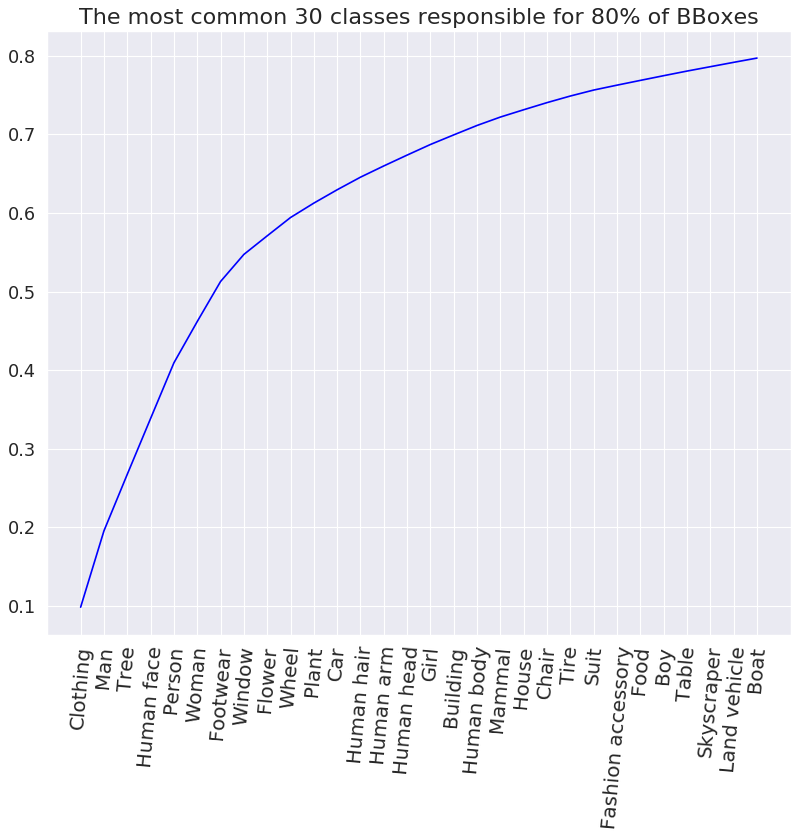

In [23]:
cum = np.cumsum(df_count_train.Percentage)

plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=85, fontsize=18)
plt.yticks(fontsize=16)
plt.title('The most common 30 classes responsible for 80% of BBoxes', fontsize=20)
plt.plot(df_count_train.LabelSemantic.iloc[:30], cum[:30], c='blue');

top30_train = df_count_train.LabelSemantic.iloc[:30]

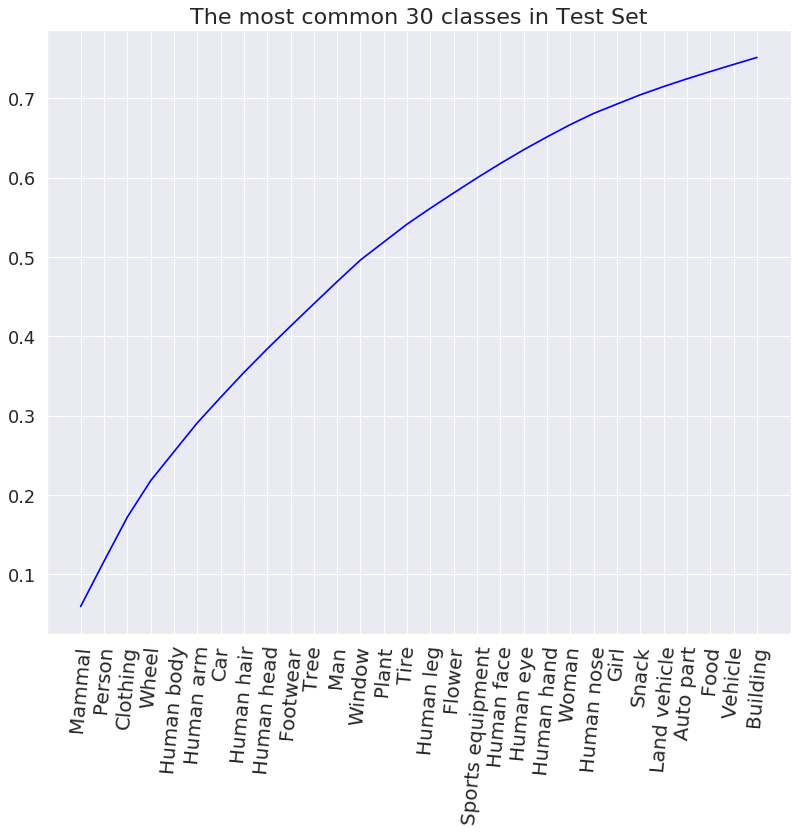

In [24]:
cum_test = np.cumsum(df_count_test.Percentage)

plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=85, fontsize=18)
plt.yticks(fontsize=16)
plt.title('The most common 30 classes in Test Set', fontsize=20)
plt.plot(df_count_test.LabelSemantic.iloc[:30], cum_test[:30], c='blue');

top30_test = df_count_test.LabelSemantic.iloc[:30]

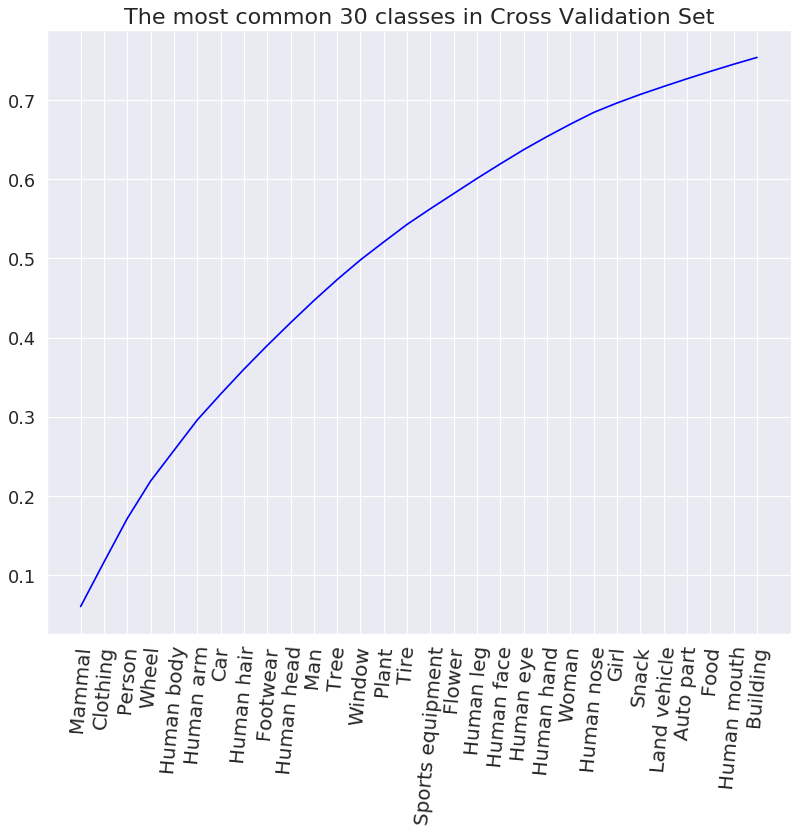

In [25]:
cum_val = np.cumsum(df_count_val.Percentage)

plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=85, fontsize=18)
plt.yticks(fontsize=16)
plt.title('The most common 30 classes in Cross Validation Set', fontsize=20)
plt.plot(df_count_val.LabelSemantic.iloc[:30], cum_val[:30], c='blue');

top30_val = df_count_val.LabelSemantic.iloc[:30]

In [26]:
relevant_classes = set(list(top30_train) + list(top30_test) + list(top30_val))

print(f"The union of the 30th classes more relevant"
      f"of each dataset results in {len(relevant_classes)} classes")

perc_train = (sum(df_count_train[df_count_train.LabelSemantic.isin(relevant_classes)].Count)
              / np.sum(df_count_train.Count))

perc_val = (sum(df_count_val[df_count_val.LabelSemantic.isin(relevant_classes)].Count)
            / np.sum(df_count_val.Count))

perc_test = (sum(df_count_test[df_count_test.LabelSemantic.isin(relevant_classes)].Count)
             / np.sum(df_count_test.Count))

print(f"Those {len(relevant_classes)} represents {perc_train*100:2.2f}% in Train Set")
print(f"Those {len(relevant_classes)} represents {perc_val*100:2.2f}% in Cross Val Set")
print(f"Those {len(relevant_classes)} represents {perc_test*100:2.2f}% in Test Set")

The union of the 30th classes more relevantof each dataset results in 39 classes
Those 39 represents 82.96% in Train Set
Those 39 represents 78.65% in Cross Val Set
Those 39 represents 78.52% in Test Set


In [49]:
relevant_classes

{'Auto part',
 'Boat',
 'Boy',
 'Building',
 'Car',
 'Chair',
 'Clothing',
 'Fashion accessory',
 'Flower',
 'Food',
 'Footwear',
 'Girl',
 'House',
 'Human arm',
 'Human body',
 'Human eye',
 'Human face',
 'Human hair',
 'Human hand',
 'Human head',
 'Human leg',
 'Human mouth',
 'Human nose',
 'Land vehicle',
 'Mammal',
 'Man',
 'Person',
 'Plant',
 'Skyscraper',
 'Snack',
 'Sports equipment',
 'Suit',
 'Table',
 'Tire',
 'Tree',
 'Vehicle',
 'Wheel',
 'Window',
 'Woman'}

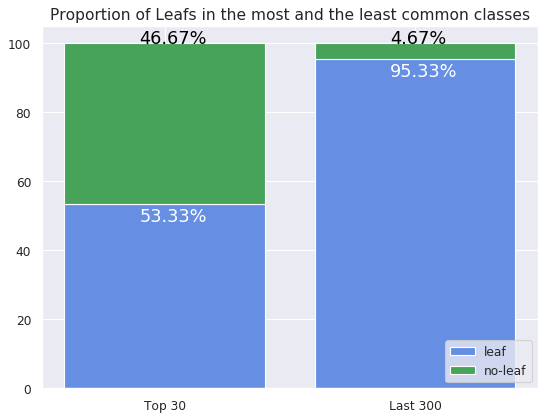

In [27]:
xs = [0, 1]
barWidth = 0.8

plt.figure(num=None, figsize=(8, 6), dpi=80)

leafs = [df_count_train.iloc[:30].query('Leaf == True').shape[0] / .3,
         df_count_train.iloc[299:].query('Leaf == True').shape[0] / 3]

noleafs = [df_count_train.iloc[:30].query('Leaf == False').shape[0] / .3,
           df_count_train.iloc[299:].query('Leaf == False').shape[0] / 3]

plt.bar(xs, leafs, width=0.8, label='leaf',
        color=sns.diverging_palette(255, 133, l=60, n=2, center="dark")[0])
plt.bar(xs, noleafs, bottom=leafs, width=0.8, label='no-leaf',
        color=sns.diverging_palette(255, 133, l=60, n=2, center="dark")[1])

plt.text(-.1, leafs[0]-5, f"{leafs[0]:2.2f}%",
         color='white', fontsize=16)
plt.text(.9, leafs[1]-5, f"{leafs[1]:2.2f}%",
         color='white', fontsize=16)

plt.xticks(xs, labels=['Top 30', 'Last 300'])

plt.text(-.1, leafs[0] + noleafs[0], f"{noleafs[0]:2.2f}%",
         color='black', fontsize=16)
plt.text(.9, leafs[1] + noleafs[1], f"{noleafs[1]:2.2f}%",
         color='black', fontsize=16)

plt.title("Proportion of Leafs in the most and the least common classes", fontsize=14)

plt.legend(loc='lower right');

In [28]:
p300 = (cum.iloc[-1] - cum.iloc[299])*100
print(f"The least common 300 classes are responsible for {p300:2.2f}% of bbox")

The least common 300 classes are responsible for 0.96% of bbox


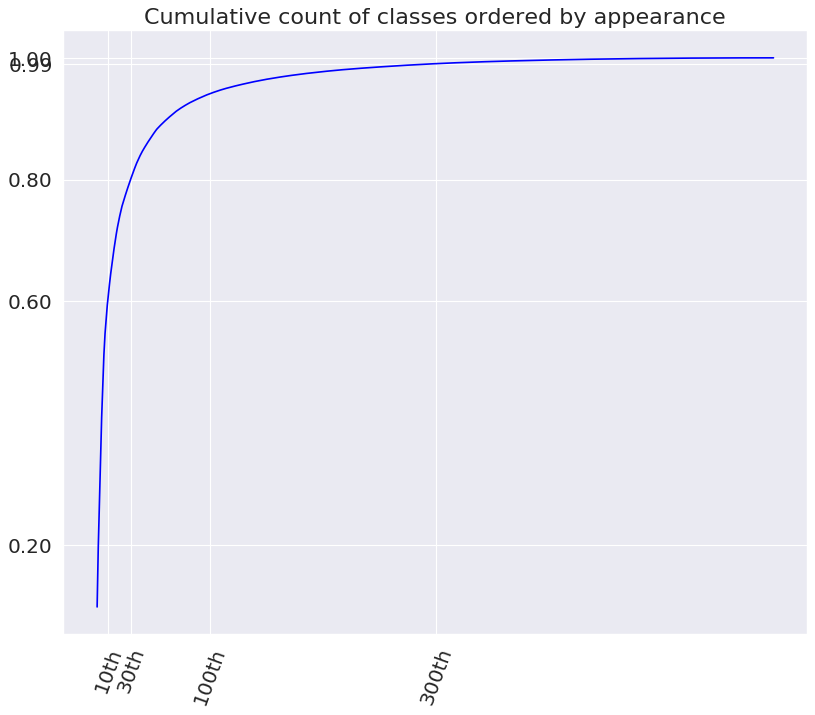

In [29]:
cum = np.cumsum(df_count_train.Percentage)

plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xticks([10, 30, 100, 300], ['10th', '30th', '100th', '300th'],
           rotation=70, fontsize=18)
plt.yticks([.2, .6, .8, .99, 1], fontsize=18)
plt.title('Cumulative count of classes ordered by appearance', fontsize=20)
plt.plot(df_count_train.LabelSemantic, cum, c='blue');

*Final Observations about Classes distributions*

I showed above how unbalanced are the classes. The thirty most present classes in bounding boxes represent 80% of all bounding boxes. Moreover, the 300 less present classes represent 0.96% of all bounding boxes. So we conclude there are many more examples of a few classes and a lack of examples for more than half of the classes.

#### Label-level

In [30]:
df_labels.sample(4, random_state=84)

ImageID        Source  LabelName  Confidence LabelSemantic  \
1118986  f3f24a71e8fce1a8  verification  /m/01g317           1        Person   
116113   c1da161e75499f48  verification  /m/014sv8           0     Human eye   
434866   3981eb7ed635fc3d  verification   /m/09j5n           1      Footwear   
6161202  2688dba4d84434b5  verification  /m/0138tl           1           Toy   

              Type  
1118986      Train  
116113   Cross-Val  
434866        Test  
6161202      Train

##### confidence

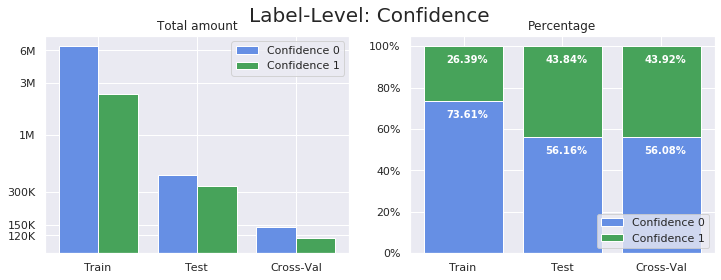

In [31]:
# Label-Level Confidence plots
feature = 'Confidence'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_labels, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [120000, 150000, 300000, 1000000, 3000000, 6000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000)}{'M' if y/1000>=1000 else 'K'}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"Label-Level: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, ['Confidence 0', 'Confidence 1'],
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, ['Confidence 0', 'Confidence 1'],
                    *percs.values())

plt.show()

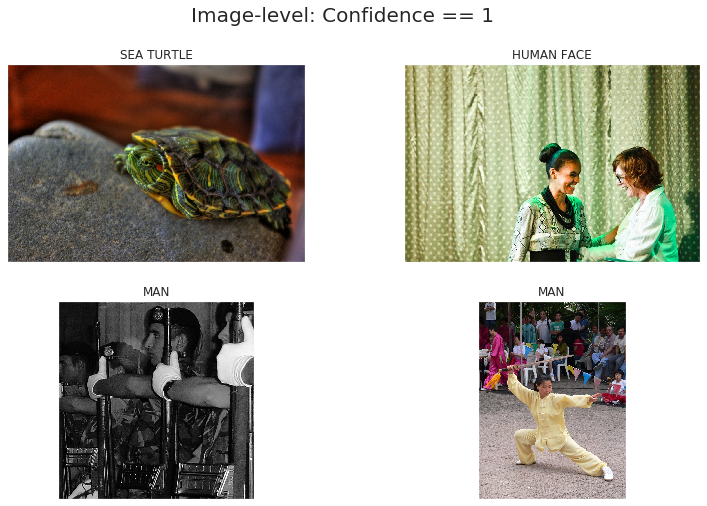

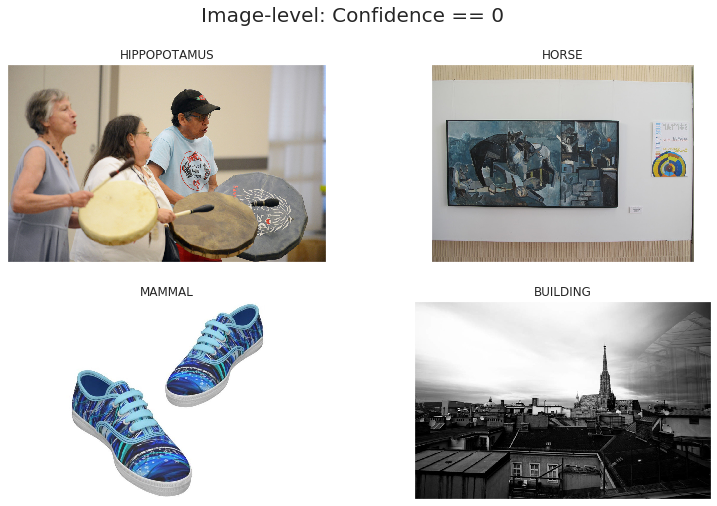

In [32]:
# Label-Level Confidence Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = 'Confidence == 1'

imgs = df_labels.query(query).sample(4, random_state=13)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_imgs(imgs, ax, df_images)

fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = 'Confidence == 0'

imgs = df_labels.query(query).sample(4, random_state=13)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_imgs(imgs, ax, df_images)


*Final Observations about Confidence in Label-Level Images*

I noticed that the confidence 1 demonstrate, as we expected, that the label is probably correct. Train has fewer proportionally labels with confidence 1, than Test and Cross-Validation sets. Even Train has a lot more examples.

##### source

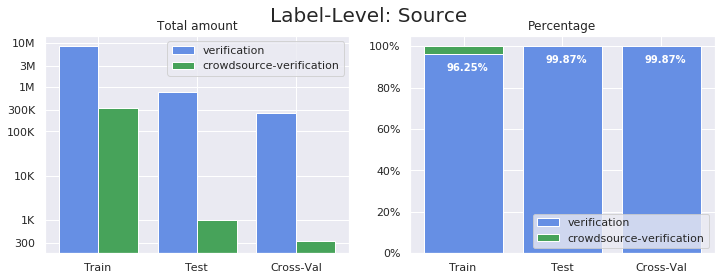

In [33]:
# Label-Level Source plots
feature = 'Source'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_labels, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [300, 1000, 10000, 100000, 300000, 1000000, 3000000, 10000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"Label-Level: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *list(counts.values()))

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

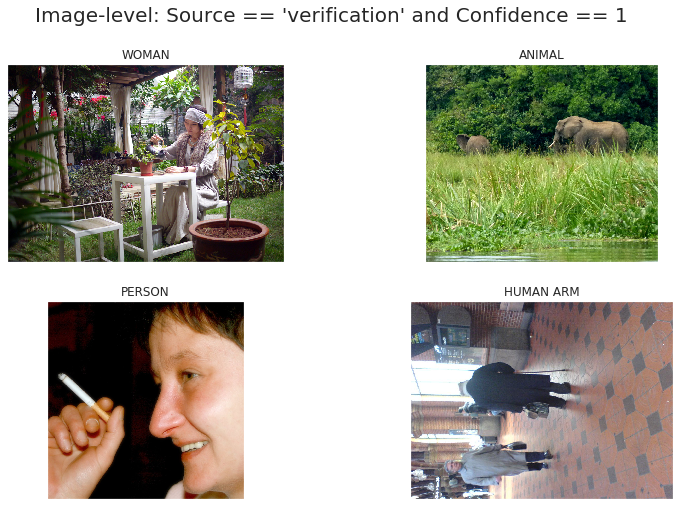

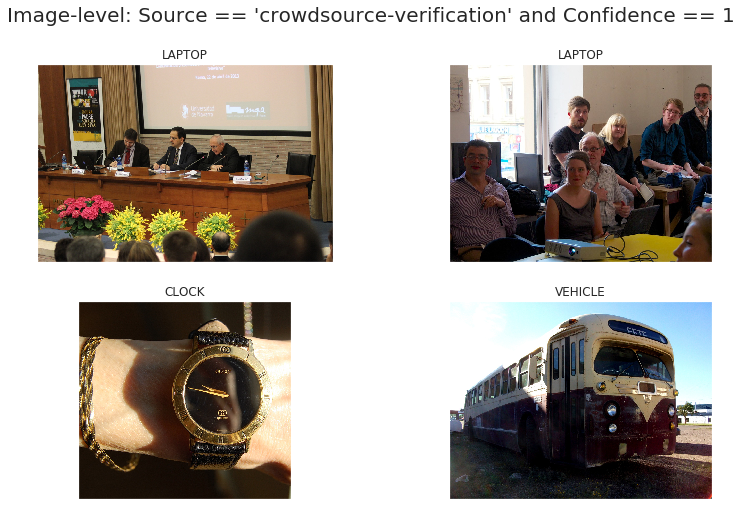

In [34]:
# Label-Level Confidence Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = "Source == 'verification' and Confidence == 1"

imgs = df_labels.query(query).sample(4, random_state=43)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_imgs(imgs, ax, df_images)

fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = "Source == 'crowdsource-verification' and Confidence == 1"

imgs = df_labels.query(query).sample(4, random_state=43)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_imgs(imgs, ax, df_images)

*Final Observations about Source in Label-Level Images*

I cannot notice an expressive difference between the two types of sources. It is easy to see that there are a lot more "Verification" than "Crowdsource-Verification"

##### correlations

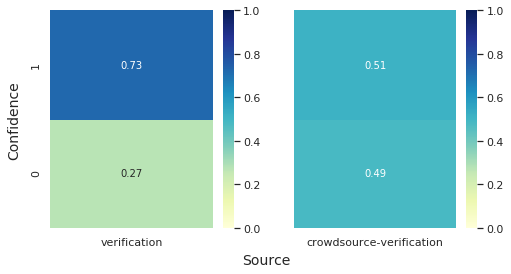

In [35]:
visuals.plot_heatmap_corr(df_labels, 'Source', 'Confidence', (8,4));

*Final Observations about Correlation between Source and Confidence in Label-Level Images*

The correlations about Source and Confidence show us that there are differences between the two types of sources. Verification kind tends to have more Confidence 1 labels than Crowdsource-Verification.

#### Bounding Boxes

In [36]:
df_bbox.sample(4, random_state=37)

ImageID  Source  LabelName  Confidence      XMin      XMax  \
148638    df6d5130f9b9577c  xclick   /m/083wq           1  0.009957  0.034139   
511027    779a23819c233802  xclick  /m/035r7c           1  0.744461  0.807976   
11084149  c4208c0087cd6544  xclick  /m/0c9ph5           1  0.660000  0.708750   
11366944  51b5d0469d674344  xclick   /m/05s2s           1  0.000000  0.999167   

              YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
148638    0.490826  0.548165           1            0          0            0   
511027    0.479029  0.543046           0            0          0            0   
11084149  0.926623  0.984008           1            0          0            0   
11366944  0.767500  0.999375           1            1          1            0   

          IsInside LabelSemantic       Type  
148638           0         Wheel  Cross-Val  
511027           0     Human leg       Test  
11084149         0        Flower      Train  
11366944         0         Plant      Train

###### Positions distributions

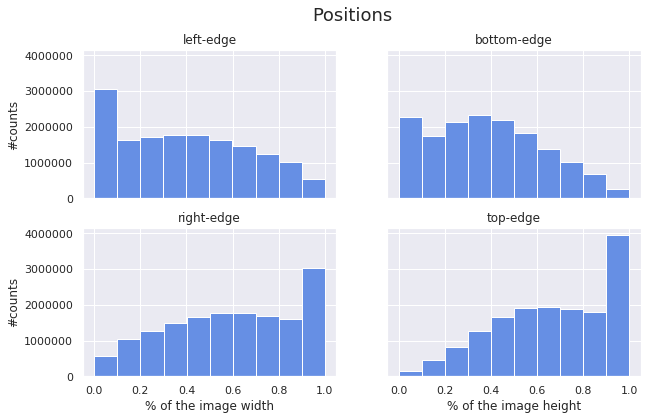

In [37]:
# BoudingBox Positions
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

fig.suptitle('Positions', fontsize=18)

axes[0, 0].hist(df_bbox.XMin)
axes[0, 0].set_ylabel('#counts')
axes[0, 0].set_title('left-edge')

axes[1, 0].hist(df_bbox.XMax)
axes[1, 0].set_ylabel('#counts')
axes[1, 0].set_xlabel('% of the image width')
axes[1, 0].set_title('right-edge')

axes[0, 1].hist(df_bbox.YMin)
axes[0, 1].set_title('bottom-edge')

axes[1, 1].hist(df_bbox.YMax)
axes[1, 1].set_title('top-edge')
axes[1, 1].set_xlabel('% of the image height');

*Final Observations about Postition in Bouding Boxes Labels*

Many of them tend to start in the most left part of the picture and ends in the most right position. Also, they tend to ends in the most bottom position.

###### Size distribution

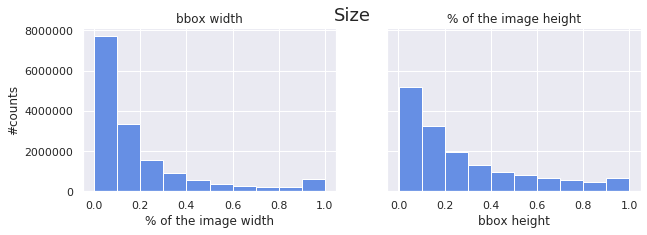

In [38]:
# size distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

fig.suptitle('Size', fontsize=18)

axes[0].hist(df_bbox.XMax - df_bbox.XMin)
axes[0].set_title('bbox width')
axes[0].set_ylabel('#counts')
axes[0].set_xlabel('% of the image width')

axes[1].hist(df_bbox.YMax - df_bbox.YMin)
axes[1].set_xlabel('bbox height')
axes[1].set_title('% of the image height');

*Final Observations about Size of Bouding Boxes Labels*

More than 50% has a width of Bounding Box less than 10% of the image width.

###### Confidence

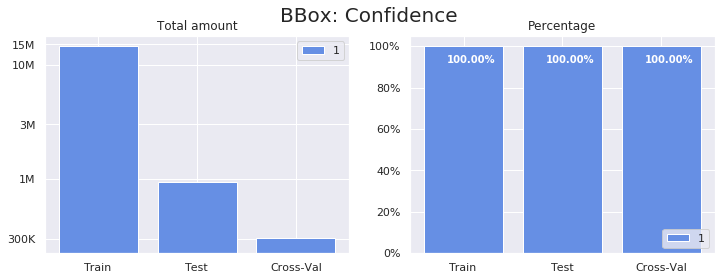

In [39]:
# Confidence plots
feature = 'Confidence'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

*Final Observations about Confidence in Bouding Boxes Labels*

There are no Confidence 0 in Bouding Boxes Labels.

###### Source

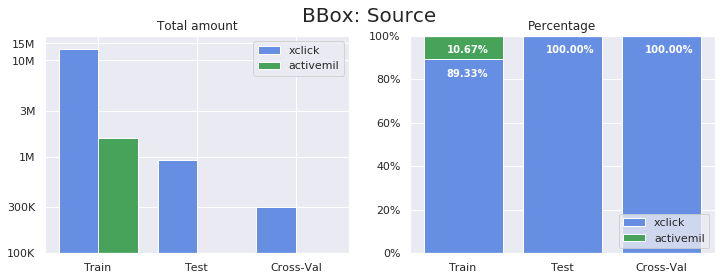

In [40]:
# BBox Source plots
feature = 'Source'
import matplotlib as mpl
# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

yticks = [100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('symlog')
ax[0].set_ylim(100000, 18000000)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

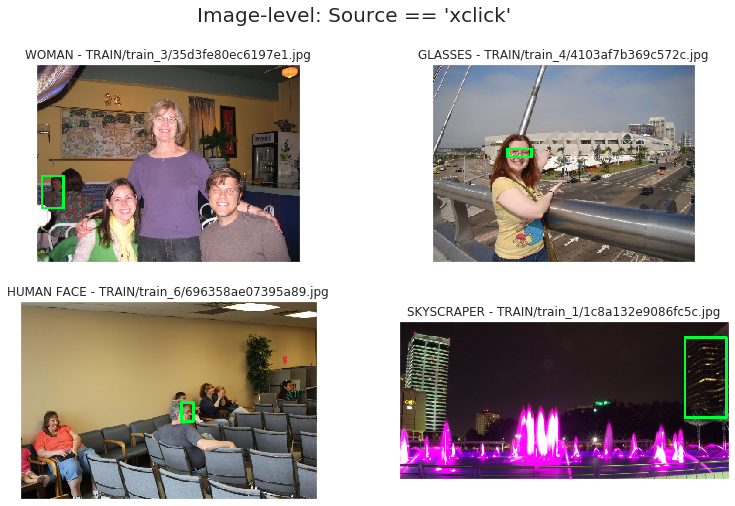

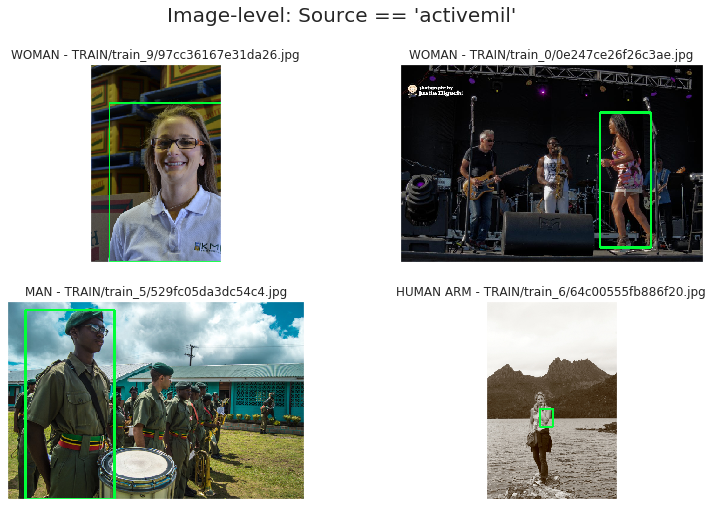

In [41]:
# BBox Source Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = "Source == 'xclick'"

imgs = df_bbox.query(query).sample(4, random_state=43)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox, print_others=False)

# BBox Source Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = "Source == 'activemil'"

imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"Image-level: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox, print_others=False)

*Final Observations about Source in Bouding Boxes Labels*

Only on Train set is the 'activemil' source, even having only around 10%. Given that there are only confidence 1, this is not going to influence the quality of the BBox Labels.

###### Distribution of IsX flags

In [42]:
(df_bbox.groupby(by='Type')
        .sum()
        [['IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside']]
        .style.format("{:,.0f}"))

###### IsOccluded

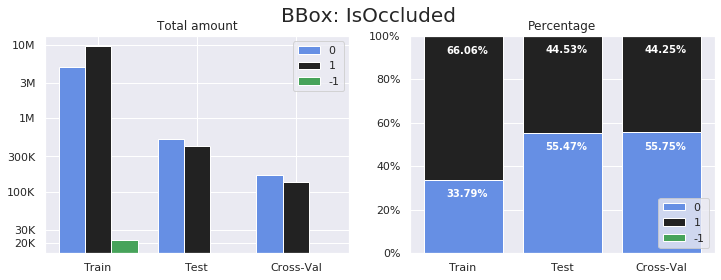

In [43]:
# BBox IsOccluded plots
feature = 'IsOccluded'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
figure, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [20000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

figure.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

KeyError: '0c5c8fa9d6cd9d67'

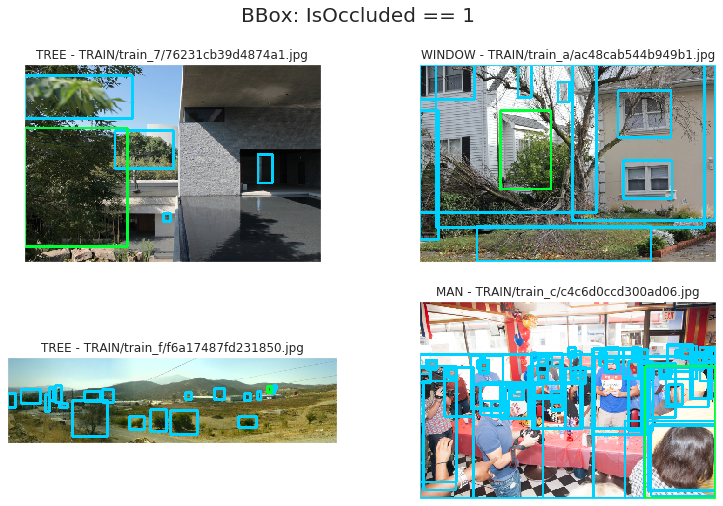

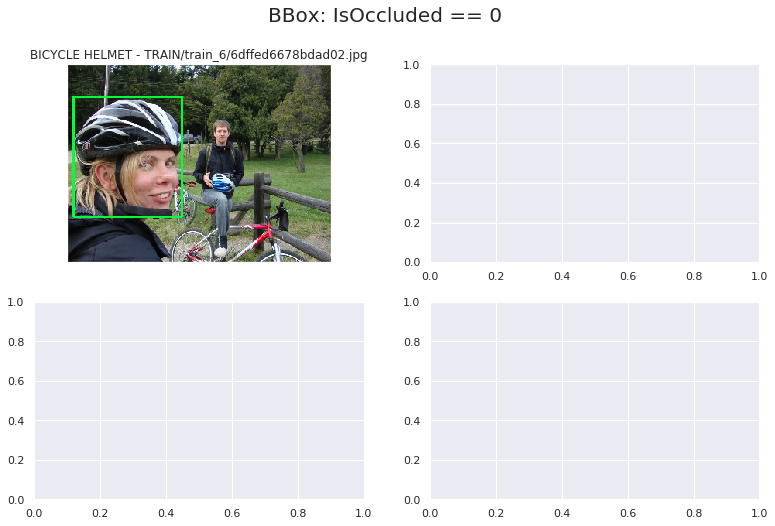

In [47]:
# BBox IsOccluded Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

feature = "IsOccluded"

# 1
query = f"{feature} == 1"
imgs = df_bbox.query(query).sample(4, random_state=42)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# 0
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == 0"
imgs = df_bbox.query(query).sample(4, random_state=23)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# -1
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == -1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

In [48]:
imgs

ImageID  Source   LabelName  Confidence      XMin  \
13933444  6dffed6678bdad02  xclick   /m/03p3bw           1  0.025000   
322850    0c5c8fa9d6cd9d67  xclick  /m/0283dt1           1  0.381375   
6476812   1fde3c4114f3d21a  xclick    /m/07j7r           1  0.209375   
8351771   8669f981ae88f32b  xclick    /m/09j2d           1  0.626415   

              XMax      YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  \
13933444  0.436250  0.167500  0.772500           0            0          0   
322850    0.614191  0.413844  0.466863           0            0          0   
6476812   0.285000  0.245833  0.310000           0            0          0   
8351771   0.900000  0.395625  0.931875           0            0          0   

          IsDepiction  IsInside   LabelSemantic   Type  
13933444            0         0  Bicycle helmet  Train  
322850              0         0     Human mouth   Test  
6476812             0         0            Tree  Train  
8351771             0         0        Clothing  Train

*Final Observations about IsOccluded in Bouding Boxes Labels*

I notice that IsOccluded flag the Bounding Boxes that have a type of obstruction in it, making him more difficult to be understandable.

###### IsTruncated

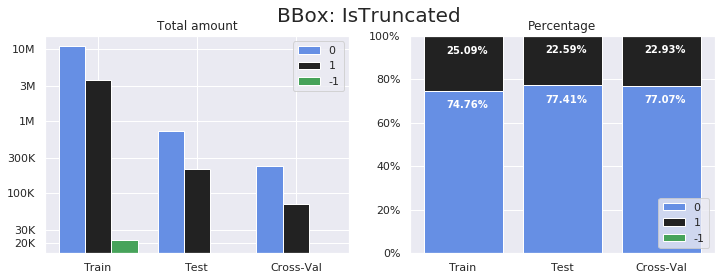

In [45]:
# BBox IsTruncated plots
feature = 'IsTruncated'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [20000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

KeyError: '074d0d3b84d42df0'

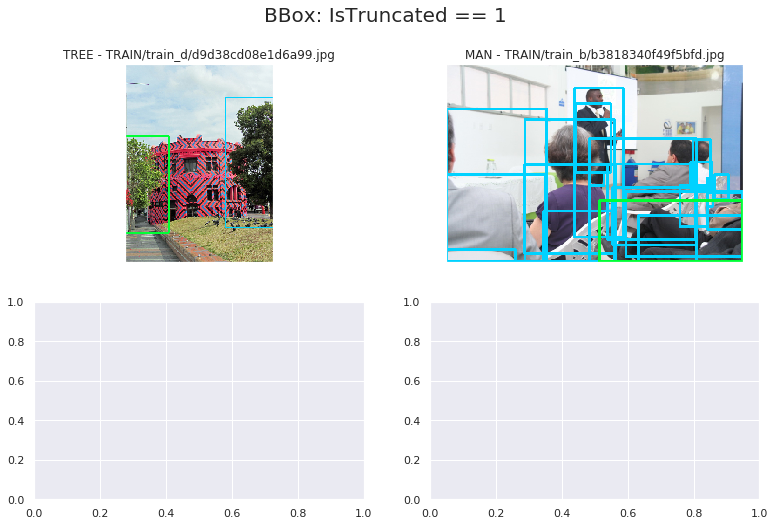

In [46]:
# BBox IsTruncated Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

feature = "IsTruncated"

# 1
query = f"{feature} == 1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# 0
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == 0"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# -1
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == -1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

*Final Observations about IsTruncated in Bouding Boxes Labels*

IsTruncated is Bounding Boxes that end or starts in some edges of the image.

###### IsGroupOf

In [ ]:
# BBox IsGroupOf plots
feature = 'IsGroupOf'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [20000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

In [ ]:
# BBox IsGroupOf Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

feature = "IsGroupOf"

# 1
query = f"{feature} == 1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# 0
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == 0"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# -1
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == -1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

*Final Observations about IsGroupOf in Bouding Boxes Labels*

IsGroupOf represents bounding boxes that label not only one thing, but a group of something.

###### IsDepiction

In [ ]:
# BBox IsDepiction plots
feature = 'IsDepiction'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [20000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

In [ ]:
# BBox IsDepiction Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

feature = "IsDepiction"

# 1
query = f"{feature} == 1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# 0
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == 0"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# -1
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == -1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

*Final Observations about IsDepection in Bouding Boxes Labels*

IsDepections are bounding boxes that label not the things itself, but a representation of the things. Draws, representation, costumes, are some examples.

###### IsInside

In [ ]:
# BBox IsInside plots
feature = 'IsInside'

# prepare date
labels, counts, percs = utils.amount_and_percentage(df_bbox, feature)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

yticks = [20000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 15000000]
ylabels = [f"{int(y/1000000 if y/1000>=1000 else y/1000 if y>=1000 else y)}"\
           f"{'M' if y/1000>=1000 else 'K' if y>=1000 else ''}"
           for y in yticks]
ax[0].set_yscale('log')
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)

fig.suptitle(f"BBox: {feature}", fontsize=20)

visuals.barplot(ax[0], f"Total amount",
                labels, list(counts.keys()),
                *counts.values())

visuals.stacked_bar(ax[1], f'Percentage',
                    labels, list(percs.keys()),
                    *list(percs.values()))

plt.show()

In [ ]:
# BBox IsInside Images
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

feature = "IsInside"

# 1
query = f"{feature} == 1"
imgs = df_bbox.query(query).sample(4, random_state=37)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# 0
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == 0"
imgs = df_bbox.query(query).sample(4, random_state=4)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

# -1
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

query = f"{feature} == -1"
imgs = df_bbox.query(query).sample(4, random_state=13)

fig.suptitle(f"BBox: {query}", fontsize=20)
visuals.show_bbox(imgs, ax, df_images, df_bbox)

*Final Observations about IsInside in Bouding Boxes Labels*

IsInside flags Bounding Boxes labeled inside rooms or buildings, with artificial light.


##### Correlations

In [ ]:
from itertools import combinations, product
columns = ['Source', 'IsOccluded', 'IsTruncated', 'IsGroupOf',
           'IsDepiction', 'IsInside']

for a, b in combinations(columns, 2):
    visuals.plot_heatmap_corr(df_bbox, a, b, (8,4))

*Final Observations about All Correlations between all Flags of Bouding Boxes Labels*

The most explicit correlation is, among all the IsX flags, the -1 in one of them implies -1 in all the others.

I also notice that activemil source tends to flag more IsOccluded and IsGroupOf than xclick. Though xclick tends to flag more IsTruncated than activemil.

Among the flags there are only three correlations that I am going to mention:
Occluded Bounding Boxes occurs more in Truncated Bounding Boxes; Group Labels occurs more in no Occluded Bounding Boxes; Also, Group Labels occurs more in Truncated Bounding Boxes.